In [51]:
import os
import glob

# packs from my setup
songs_path = 'C:\\Users\\Lenovo\\AppData\\Roaming\\ITGmania\\Songs'
pack_names = [
    # 'Stamina RPG 6',
    # 'SRPG6 NNP',
    # 'Stamina RPG 7',
    # 'Stamina RPG 7 - SN',
    # 'Stamina RPG 7 - FE',
    # 'Stamina RPG 8',
    # 'Stamina RPG 8 - SN',
    # 'Stamina RPG 8 - FE',
    # 'Stamina RPG 9',
    # 'Stamina RPG 9 - SN',
    # 'Stamina RPG 9 - FE',
]
pack_paths = [os.path.join(songs_path, name) for name in pack_names]

glob_path = '.\\packs\\*'
pack_paths += glob.glob(glob_path)

In [52]:
from simfile.dir import SimfilePack
from analysis.analyzer import SongAnalyzer
from analysis.hash import get_hash
import pandas as pd
import math

try:
    existing_df = pd.read_csv('rnn2_dataset.csv')
    seen_hashes = set(existing_df['Hash'])
except FileNotFoundError:
    existing_df = None
    seen_hashes = set()

data = []
for pack_path in pack_paths:
    pack = SimfilePack(pack_path)
    for song in pack.simfiles(strict=False):
        song_analyzer = SongAnalyzer(song)
        song_str = f'{pack.name}/{song.title or ""}'

        for chart_analyzer in song_analyzer.chart_analyzers.values():
            chart = chart_analyzer.chart
            if (chart.stepstype or '').lower() != 'dance-single':
                continue
            diff = (chart.difficulty or '').lower()
            title = song_str
            if diff != 'challenge':
                title += f' ({diff})'

            chart_hash = get_hash(song, chart_analyzer.chart)
            if chart_hash in seen_hashes:
                print(f'skipping {title} (dupe hash)')
                continue
            seen_hashes.add(chart_hash)
            print(f'analyzing {title}')
            try:
                meter = int(chart_analyzer.chart.meter)
            except ValueError:
                print(song.title, ': invalid meter')
                continue

            npm_bpm_pairs = chart_analyzer.get_stream_info()['npm_bpm_pairs']
            # npm_bps_pairs = [[npm, round(bpm/60, 6)] for npm, bpm in npm_bpm_pairs]
            nps_len_pairs = []
            cur_nps = None
            cur_len = 0
            for npm, bpm in npm_bpm_pairs:
                measure_len = (60 / bpm) * 4
                nps = npm / measure_len
                nps = round(nps, 6)
                if cur_nps is not None and cur_nps != nps:
                    nps_len_pairs.append([cur_nps, math.log2(cur_len+1)])
                    cur_len = 0
                cur_nps = nps
                cur_len += measure_len
            if cur_nps is not None:
                nps_len_pairs.append([cur_nps, math.log2(cur_len+1)])            
            #print(nps_len_pairs)

            if len(nps_len_pairs) == 0:
                print(title, ': empty')
            else:
                data.append((
                    title,
                    chart_hash,
                    meter,
                    nps_len_pairs
                ))

skipping ECS11 - Lower/[12] [150] Blood Is Pumpin' (Hard) (dupe hash)
skipping ECS11 - Lower/[12] [133] Crazy Loop (dupe hash)
skipping ECS11 - Lower/[12] [130] Discovery (dupe hash)
skipping ECS11 - Lower/[12] [160] Drink (dupe hash)
skipping ECS11 - Lower/[12] [160] Ghost (dupe hash)
skipping ECS11 - Lower/[12] [160] Gimme Your Desire (Hard) (dupe hash)
skipping ECS11 - Lower/[12] [140] Higanbana (dupe hash)
skipping ECS11 - Lower/[12] [135] I'm Coming (dupe hash)
skipping ECS11 - Lower/[12] [150] Lifelight (Camellia's Hardstyle Bootleg) (dupe hash)
skipping ECS11 - Lower/[12] [138] Mind Echoes (dupe hash)
skipping ECS11 - Lower/[12] [150] Purple Lamborghini (dupe hash)
skipping ECS11 - Lower/[12] [140] Sense 2007 (dupe hash)
skipping ECS11 - Lower/[12] [160] Stay Awake (Hard) (dupe hash)
skipping ECS11 - Lower/[12] [150] The Sampling Paradise (dupe hash)
skipping ECS11 - Lower/[12] [146] Wastelands (dupe hash)
skipping ECS11 - Lower/[12] [140] Zi-Zi's Journey (dupe hash)
skipping EC

In [23]:
data = [row[:-1] + ([[a, b] for a, b in row[-1]],) for row in data]

In [53]:
columns = ['Name', 'Hash', 'Meter', 'Sequence']

df = pd.DataFrame(data, columns=columns)
if existing_df is not None:
    df = pd.concat([existing_df, df], axis=0, ignore_index=True)
df

,Name,Hash,Meter,Sequence
0,Stamina RPG 6/[11] [128] Alcohol-Free,0b020e29c3919c10c1d3fb2776e813b18af30114,11,"[[0.0, 3.0874628412503395], [8.533333, 2.72792..."
1,Stamina RPG 6/[11] [136] Cowboy,f2bc769bdf7addfc64d7e46643e194f184820a56,11,"[[7.933333, 2.1793236994445615], [2.266667, 1...."
2,Stamina RPG 6/[11] [136] Flutterwonder (Hard),fc05556c0b501fabafe79a16923e910518d5d03d,11,"[[0.0, 3.918161707943539], [0.566667, 1.467126..."
3,Stamina RPG 6/[11] [124] Glory Days,c0b5988bae418d86ccac7c7209f605932857bb81,11,"[[0.0, 3.416491096420342], [4.133333, 2.766902..."
4,Stamina RPG 6/[11] [145] Hawaiian Roller Coast...,d0b51e7437f6705f45bf6d9c1254964330bfcc4e,11,"[[0.0, 3.2134813674290523], [7.25, 1.408805545..."
...,...,...,...,...
3103,jubeat fof/ZED (easy),0990c3c06a3a00942061b4dad49ac725f3439e8c,32,"[[0.0, 1.1783372412585125], [3.166667, 0.70626..."
3104,jubeat fof/ZED (medium),3ee2363fec284e7536150254c5edd67401dcdbbf,33,"[[0.0, 1.1783372412585125], [3.166667, 0.70626..."
3105,jubeat fof/ZED (hard),eb58190f8d4a2a3a07d578ea4874faf437919df9,34,"[[0.0, 1.1783372412585125], [3.166667, 0.70626..."
3106,jubeat fof/ZED,1fae6f7b9642e0d12c841c53f4e61dba66629b1a,35,"[[0.0, 1.1783372412585125], [3.166667, 0.70626..."


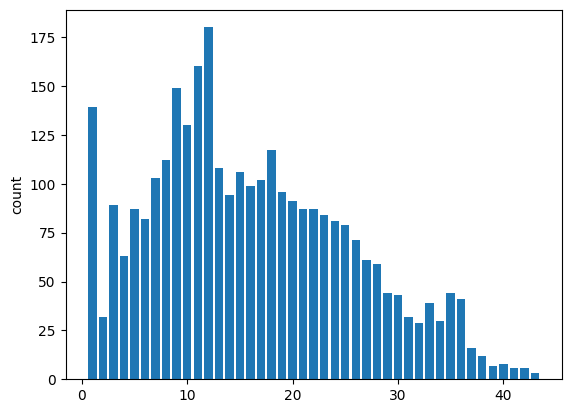

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

meter_counts = df['Meter'].value_counts().sort_index()
meters = meter_counts.index.to_numpy()
counts = meter_counts

ax.bar(meters, counts)

ax.set_ylabel('count')

plt.show()

In [55]:
df.to_csv('rnn2_dataset.csv', index=False)